In [1]:
import pandas as pd
import numpy as np
from datetime import datetime , timedelta 
import yfinance as yf  #import data via Yahoo
from scipy.stats import multivariate_normal
from sklearn.mixture import GaussianMixture
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import scipy.stats as ss

Source Article here: https://medium.datadriveninvestor.com/using-an-unsupervised-machine-learning-algorithm-to-detect-different-stock-market-regimes-5c6354a1826a

My blog here: https://www.dwongresearch.com/

Create the downloader function and download the data we need

In [2]:
def getYahooData(symbol, start = '2000-01-01' ):
    """
    Get a pandas dataframe using a yahoo symbol from start date until yesterday as a business day.
    args:
        symbol - str
        start - str in YYYY-MM-DD format
        
    return:
        pd.DataFrame
    """
    today = datetime.today()
    # dd/mm/YY
    #get last business day
    offset = max(1, (today.weekday() + 6) % 7 - 3)
    timed = timedelta(offset)
    today_business = today - timed
    print("d1 =", today_business)
    today = today_business.strftime("%Y-%m-%d")
    symbols_list = [symbol]
    start = '2000-01-01' 
    end = today
    print('{symbol} is Downloading'.format(symbol=symbol))
    r = yf.download(symbols_list, start,end)
    df_pivot = r
    
    return df_pivot

In [3]:
SPY = getYahooData('SPY')
TNX = getYahooData('^TNX')

d1 = 2022-03-18 16:15:06.936167
SPY is Downloading
[*********************100%***********************]  1 of 1 completed
d1 = 2022-03-18 16:15:07.284425
^TNX is Downloading
[*********************100%***********************]  1 of 1 completed


In the original example code, the author says they used log returns. However in the actual codebase it was percentage returns.
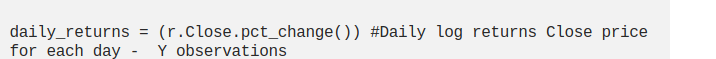

I amend that by actually implementing log returns. Log returns have a lot of good characteristics so I prefer them anyway, however we will begin to deviate from the original source results.

We also drop the first NAN by creating a returns series

In [4]:
spy_log_rets = np.log(SPY['Adj Close']/SPY['Adj Close'].shift(1)).dropna()
tnx_log_rets = np.log(TNX['Adj Close']/TNX['Adj Close'].shift(1)).dropna() 

Do a quick sanity check on the log returns series

In [ ]:
spy_log_rets.plot(kind="hist", bins=50)

In [ ]:
tnx_log_rets.plot(kind="hist", bins=50)

Fit the GMM using 3 states and only SP500 data as in Senario 1 of the example

In [ ]:
X = spy_log_rets.values
GMM = GaussianMixture(n_components=3).fit(X.reshape(-1,1)) # Instantiate and fit the model

In [ ]:
# check convergance
GMM.converged_

In [ ]:
# create search space of -10% to +10% per day
x = np.linspace(-0.1,0.1, 5000)

We need to seperate out each of the 3 guassians and plot them to see their regimes

In [ ]:
GMM_means = GMM.means_.ravel()
GMM_weights = GMM.weights_
# Convert covairances to standard devation of each mixture
cov = GMM.covariances_
GMM_stdDev = [ np.sqrt( np.trace(cov[i])/3) for i in range(0,3) ]

In [ ]:
pdfs = [p * ss.norm.pdf(x, mu, std) for mu, std, p in zip(GMM.means_.ravel(), GMM_stdDev, GMM_weights)]

In [ ]:
# Individual PDFs - comment out the ones you dont want to plot
fig = make_subplots(specs=[[{"secondary_y": True}]])

# fig.add_trace(go.Scatter(x=x, y=pdfs[0], name='Gaussian Mixture PDF 1'), secondary_y=True)
# fig.add_trace(go.Scatter(x=x, y=pdfs[1], name='Gaussian Mixture PDF 2'), secondary_y=True)
# fig.add_trace(go.Scatter(x=x, y=pdfs[2], name='Gaussian Mixture PDF 3'), secondary_y=True)
fig.add_trace(go.Scatter(x=x, y=pdfs[0]+pdfs[1]+pdfs[2], name='Gaussian Mixture Total PDF'), secondary_y=True)

# fig.add_trace(go.Histogram(x=spy_log_rets.values, name='SPY Log Returns'),
#                         secondary_y=False)
# fig.update_yaxes(rangemode='tozero')

In [ ]:
# Total PDF overlay SP500
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Scatter(x=x, y=pdfs[0]+pdfs[1]+pdfs[2], name='Gaussian Mixture Total PDF'), secondary_y=True)

fig.add_trace(go.Histogram(x=spy_log_rets.values, name='SPY Log Returns',histnorm='probability'),
                        secondary_y=False)
fig.update_yaxes(rangemode='tozero')

# fig.show()